# 01 - BigQuery - Table Data Source
Use BigQuery to load and prepare data for machine learning:

### Overview:
-  Setup BigQuery
   -  Create a Dataset
      -  Use BigQuery Python Client
   -  Create Tables
      -  Copy from another Project:Dataset
         -  SQL with BigQuery Jupyter Magic (%%bigquery)
      -  Load data from GCS Bucket
         -  BigQuery Python Client (load_table_from_uri)
   -  Prepare Data For Analysis
      -  Run SQL Queries to prepare Unique ID's and Train/Test Splits

### Resources:
-  [Python Client For Google BigQuery](https://googleapis.dev/python/bigquery/latest/index.html)
-  [Download BigQuery Data to Pandas](https://cloud.google.com/bigquery/docs/bigquery-storage-python-pandas)
-  [BigQuery Template Notebooks](https://github.com/GoogleCloudPlatform/bigquery-notebooks/tree/main/notebooks/official/template_notebooks)



---
## Source Data

**Overview**

This notebook imports source data for this project into Google BigQuery.  All the remaining notebooks utilize BigQuery as the source and leverage API's native to the machine learning approaches they feature.

* In the enviornment setup notebook (00), a BigQuery source table was exported to CSV format in a Cloud Storage Bucket. 
* This notebook, `01 - BigQuery - Table Data Source`, start the machine learning lifecycle by importing a source and preparing it for machine learning.  To customize this series of notebooks change the source referenced here or in notebook `00 - Environment Setup`.

* All of these workflows utilize tabular data to fit a supervised learning model: predict a target variable by learning patterns in feature columns.  
* The type of supervised learning used in these projects is classification: models with a target variable that has multiple discrete classes.  

**The Data**

The source data is exported to Google Cloud Storage in CSV format by the `00 - Environment Setup` notebook.  The BigQuery source table is `bigquery-public-data.ml_datasets.ulb_fraud_detection`.  This is a table of credit card transactions that are classified as fradulant, `Class = 1`, or normal `Class = 0`.  

The data can be researched further at this [Kaggle link](https://www.kaggle.com/mlg-ulb/creditcardfraud).

**Description of the Data**

This is a table of 284,207 credit card transactions classified as fradulant or normal in the column `Class`.  In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction
>**Quick Note on PCA**

>PCA is an unsupervised learning technique: there is not a target variable.  PCA is commonlly used as a variable/feature reduction technique.  If you have 100 features then you could reduce it to a number p (say 10) projected features.  The choice of this number is a balance of how well it can explain the variance of the full feature space and reducing the number of features.  Each projected feature is orthogonal to each other feature, meaning there is no correlation between these new projected features.

**Preparation of the Data**

This notebook adds two columns to the source data and stores it in a new table with suffix `_prepped`.  
- `transaction_id` (string) a unique id for the row/transaction
- `splits` (string) this divided the tranactions into sets for `TRAIN` (80%), `VALIDATA` (10%), and `TEST` (10%)

---
## Setup

inputs:

In [1]:
PROJECT_ID = "nguyen-demo5"
REGION = 'us-central1'
DATANAME = 'taxi'
NOTEBOOK = '01'

packages:

In [2]:
from google.cloud import bigquery

clients:

In [3]:
bq = bigquery.Client(project = PROJECT_ID)

parameters:

In [4]:
BUCKET = PROJECT_ID

---
## Create Dataset

List BigQuery datasets in the project:

In [5]:
query = f"""
SELECT schema_name
FROM `{PROJECT_ID}.INFORMATION_SCHEMA.SCHEMATA`
"""
bq.query(query = query).to_dataframe()

,schema_name


Create the dataset if missing:

In [6]:
query = f"""
CREATE SCHEMA IF NOT EXISTS `{PROJECT_ID}.{DATANAME}`
OPTIONS(
    location = '{REGION}',
    labels = [('notebook','{NOTEBOOK}')]
)
"""
job = bq.query(query = query)
job.result()

In [7]:
(job.ended-job.started).total_seconds()

0.179

---
## Create Table
- import data from Cloud Storage Bucket
- https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-csv

In [8]:
destination = bigquery.TableReference.from_string(f"{PROJECT_ID}.{DATANAME}.{DATANAME}")
job_config = bigquery.LoadJobConfig(
    write_disposition = 'WRITE_TRUNCATE',
    source_format = bigquery.SourceFormat.CSV,
    autodetect = True,
    labels = {'notebook':f'{NOTEBOOK}'}
)
job = bq.load_table_from_uri(f"gs://{BUCKET}/{DATANAME}/data/{DATANAME}_*.csv", destination, job_config = job_config)
job.result()

LoadJob<project=nguyen-demo5, location=us-central1, id=01da02bf-f2d7-4d85-8e76-fe0e6a950301>

In [9]:
(job.ended-job.started).total_seconds()

31.818

### Check out this table in BigQuery Console:
- Click: https://console.cloud.google.com/bigquery
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and review the dataset and table

---
## Review Data
Additional SQL queries could be used to review the data.  This section shows moving the table to a Pandas dataframe for local review in Python:

In [ ]:
#query = f"""
#SELECT *
#FROM `{DATANAME}.{DATANAME}`
#"""
#df = bq.query(query = query).to_dataframe()

---
## Prepare Data for Analysis

Create a prepped version of the data with test/train splits using SQL DDL:

In [6]:
query = f"""
CREATE OR REPLACE TABLE `{DATANAME}.{DATANAME}_notnull` AS
SELECT
  *
FROM
  `{DATANAME}.{DATANAME}`
WHERE
  tips IS NOT NULL
  AND trip_seconds IS NOT NULL
  AND trip_miles IS NOT NULL
  AND fare IS NOT NULL
  AND tolls IS NOT NULL
  AND pickup_location IS NOT NULL
  AND dropoff_location IS NOT NULL
  AND pickup_latitude IS NOT NULL
  AND pickup_longitude IS NOT NULL
  AND dropoff_latitude IS NOT NULL
  AND dropoff_longitude IS NOT NULL
  AND company IS NOT NULL
  AND trip_miles > 1
  AND trip_seconds > 180
"""
job = bq.query(query = query)
job.result()

In [7]:
(job.ended-job.started).total_seconds()

16.921

In [8]:
job.estimated_bytes_processed/1000000 #MB

73020.187269

Review the test/train split:

In [9]:
query = f"""
SELECT payment_type, count(*) as Count, 100*count(*) / (sum(count(*)) OVER()) as Percentage
FROM `{DATANAME}.{DATANAME}_notnull`
GROUP BY payment_type
"""
bq.query(query = query).to_dataframe()

,payment_type,Count,Percentage
0,Credit Card,26052429,46.395976
1,Pcard,7018,0.012498
2,Prcard,942643,1.678724
3,No Charge,276520,0.492446
4,Unknown,466041,0.829958
5,Dispute,33859,0.060298
6,Way2ride,75,0.000134
7,Prepaid,1267,0.002256
8,Cash,27759141,49.435407
9,Split,2263,0.004030


Retrieve a subset of the data to a Pandas dataframe:

In [10]:
query = f"""
SELECT * 
FROM `{DATANAME}.{DATANAME}_notnull`
LIMIT 5
"""
data = bq.query(query = query).to_dataframe()

In [20]:
#data.head()

**The distribution of the records in the taxi_trips table**

In [13]:
query = f"""
SELECT
EXTRACT (YEAR
  FROM
    trip_start_timestamp) year,
  EXTRACT (MONTH
  FROM
    trip_start_timestamp) month,
  COUNT(*) total
FROM
  `nguyen-demo5.taxi.taxi`
WHERE
  tips IS NOT NULL
  AND trip_seconds IS NOT NULL
  AND trip_miles IS NOT NULL
  AND fare IS NOT NULL
  AND tolls IS NOT NULL
  AND pickup_location IS NOT NULL
  AND dropoff_location IS NOT NULL
  AND pickup_latitude IS NOT NULL
  AND pickup_longitude IS NOT NULL
  AND dropoff_latitude IS NOT NULL
  AND dropoff_longitude IS NOT NULL
  AND company IS NOT NULL
  AND trip_miles > 1
  AND trip_seconds > 180
GROUP BY
  year,
  month
ORDER BY
  year,
  month ASC;
"""
data = bq.query(query = query).to_dataframe()

In [19]:
data.head(10)

,year,month,total
0,2013,1,143911
1,2013,2,149998
2,2013,3,177592
3,2013,4,162713
4,2013,5,171316
5,2013,6,181596
6,2013,7,175618
7,2013,8,198611
8,2013,9,195032
9,2013,10,264394


#### Connect data to tableau for visualization:
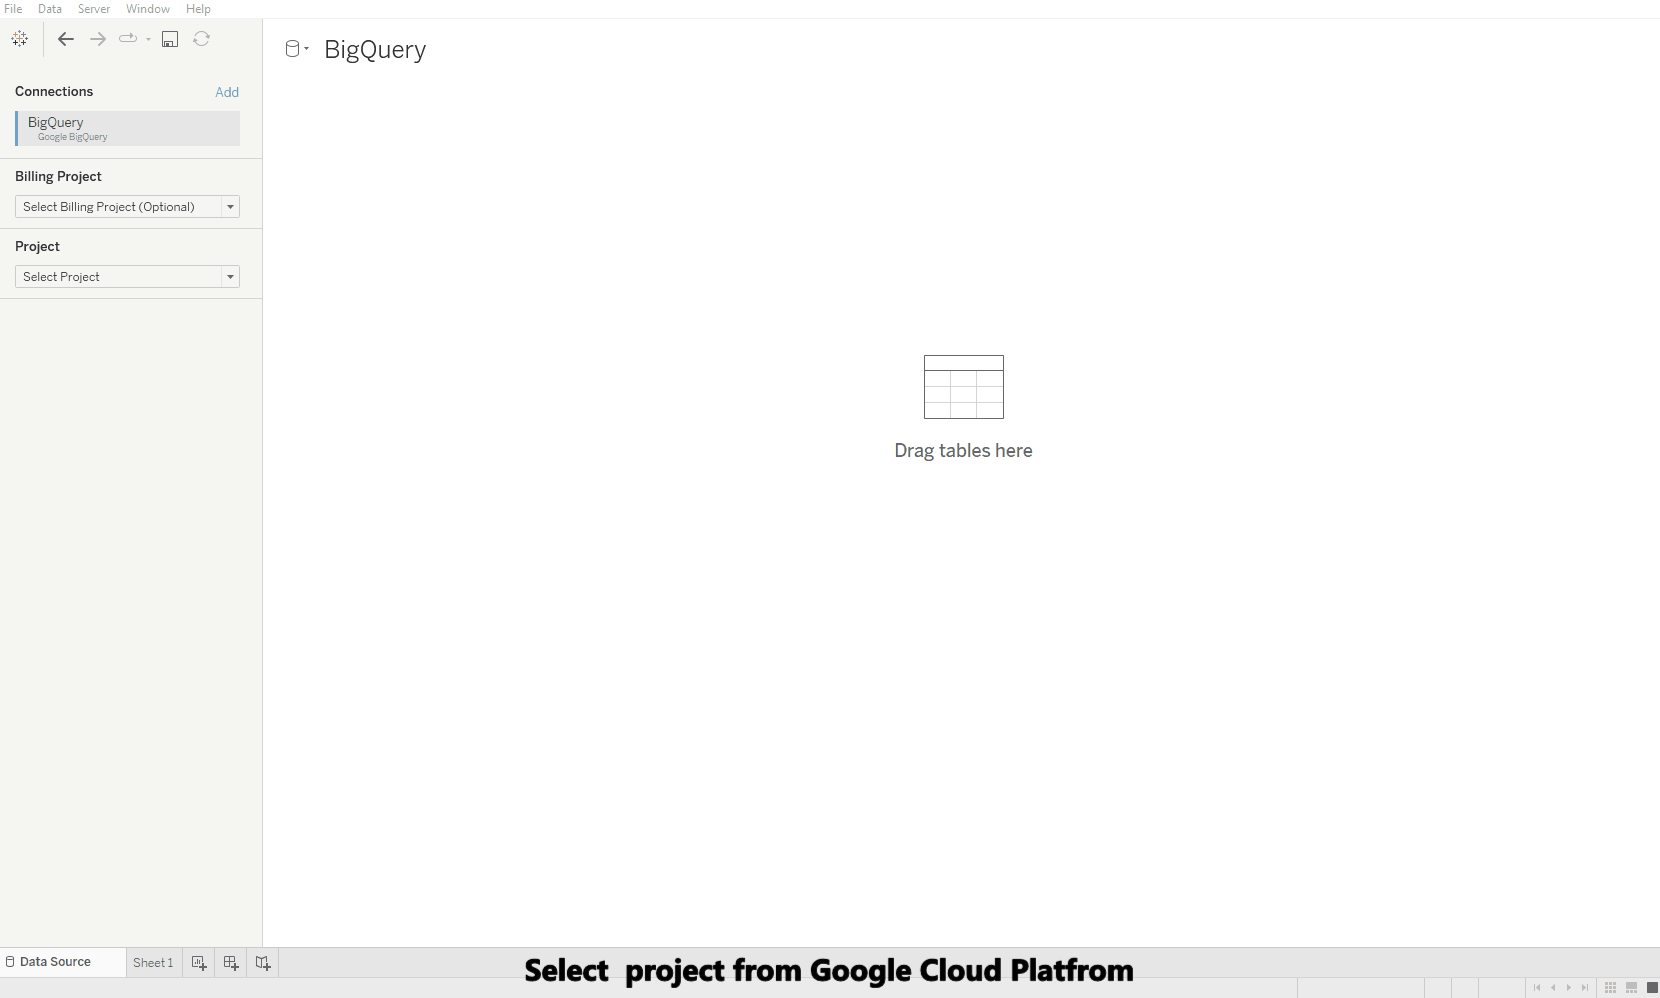

#### The distribution of the records in the taxi_trips table:

* Focusing on the most recent months, we can immediately notice a drop in the
numbers in April 2020. 
* This sudden decrease is probably caused by the restrictions
introduced to manage the COVID-19 pandemic. 
* To avoid any impact of this event
on our analysis, let's focus our implementation only on the year 2019.

---
## Remove Resources
see notebook "99 - Cleanup"